Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [111]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [112]:
#model_name = 'psm'
model_name = 'psm_simplified'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [113]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []

if (model_name == 'psm_simplified'):   
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_pitch2yaw = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
#     L_23 = 5
    L_24 = 5
#     L_25 = 6
    L_30 = 6
    L_31 = 7
    L_4 = 8
    L_5 = 9
    L_6 = 10
    L_7 = 11
    M_6 = 12
    M_7 = 13
    F_67 = 14
    
    
    x = [None]*15
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,         False, False, False) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,  True,  False, True) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,  True,  False, True) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22],                l_2L3,       0,      0,              _pi/2,     False, False, False) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_30],          l_2H1,       0,      0,              -q2+_pi/2, True,  False, False) # Pitch Front                                    )
    #x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False)    # Intermediate
    x[5]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,        True,  False, False)    # Pitch Bottom
    #x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False)    # Pitch Top
    x[6]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2,  q3-l_RCC+l_2H1, 0,         True,  False, True)    # Pitch End
    x[7]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,         True,  False, False)    # Main Insertion
    x[8] = (L_4,  L_30, [L_5],                  0,           0,      l_tool,         q4,        False, True,  True) # Intermediate Counterweight
    x[9] = (L_5,  L_4,  [L_6, L_7],             0,           _pi/2,  0,              q8+_pi/2,  False, True,  True) # Counterweight
    x[10] = (L_6,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q9+_pi/2,  False, False,  True) # Tool Roll 
    x[11] = (L_7,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q10+_pi/2,  False, False,  True) # Tool Pitch
    
    x[12] = (M_6,  L_b,  [],                    0,           0,      0,              q6,        False, True,  True) # Tool Yaw1 inert
    x[13] = (M_7,  L_b,  [],                    0,           0,      0,              q7,        False, True,  True) # Tool Yaw2 inert
    x[14] = (F_67, L_b,  [],                    0,           0,      0,              q10-q9,    False, False, True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
elif (model_name == 'psm'):
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_pitch2yaw = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
    L_23 = 5
    L_24 = 6
    L_25 = 7
    L_30 = 8
    L_31 = 9
    L_4 = 10
    L_5 = 11
    L_6 = 12
    L_7 = 13
    M_6 = 14
    M_7 = 15
    F_67 = 16
    
    
    x = [None]*17
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,         False, False, False) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,  True,  False, True) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,  True,  False, True) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22, L_23],          l_2L3,       0,      0,              _pi/2,     False, False, False) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_25, L_30],    l_2H1,       0,      0,              -q2+_pi/2, True,  False, False) # Pitch Front                                    )
    x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False)    # Intermediate
    x[6]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,        True,  False, False)    # Pitch Bottom
    x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False)    # Pitch Top
    x[8]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2,  q3-l_RCC+l_2H1, 0,         True,  False, True)    # Pitch End
    x[9]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,         True,  False, False)    # Main Insertion
    x[10] = (L_4,  L_30, [L_5],                 0,           0,      l_tool,         q4,        False, True,  True) # Intermediate Counterweight
    x[11] = (L_5,  L_4,  [L_6, L_7],            0,           _pi/2,  0,              q8+_pi/2,  False, True,  True) # Counterweight
    x[12] = (L_6,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q9+_pi/2,  False, False,  True) # Tool Roll 
    x[13] = (L_7,  L_5,  [],                    l_pitch2yaw, -_pi/2, 0,              q10+_pi/2,  False, False,  True) # Tool Pitch
    
    x[14] = (M_6,  L_b,  [],                    0,           0,      0,              q6,        False, True,  True) # Tool Yaw1 inert
    x[15] = (M_7,  L_b,  [],                    0,           0,      0,              q7,        False, True,  True) # Tool Yaw2 inert
    x[16] = (F_67, L_b,  [],                    0,           0,      0,              q10-q9,    False, False, True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     dh_convention='mdh',
                     friction_type=friction_type)

psm_simplified
['Coulomb', 'viscous', 'offset']


In [26]:
M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
M_motor2model_q = np.linalg.inv(M_model2dvrk_q)*M_motor2dvrk_q
M_motor2model_q[np.abs(M_motor2model_q) < 0.0001] = 0
M_motor2model_q

matrix([[ 1.0186 ,  0.     ,  0.     ],
        [-0.8306 ,  1.21775,  0.     ],
        [-0.8306 ,  0.     ,  1.21775]])

In [27]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R', 'R']

In [28]:
robot_def.bary_params

## Create kinematics chain

In [29]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
CPU times: user 11min 9s, sys: 2.19 s, total: 11min 11s
Wall time: 11min 9s


In [30]:
angle = [0, 0.0, 0, 0, 0, 0.3, 0.4]
geom.draw_geom(angle)

## Create dynamics

In [31]:
dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/14
Calculating the link kinetic energy of 2/14
Calculating the link kinetic energy of 4/14
Calculating the link kinetic energy of 5/14
Calculating the link kinetic energy of 6/14
Calculating the link kinetic energy of 7/14
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating regressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 48
Creating H_b function...
Finished creating robot dynamics


In [32]:
sympy.Matrix(dyn.base_param)

⎡                                                              1.0⋅m₆         
⎢                                                                             
⎢                                                              1.0⋅m₇         
⎢                                                                             
⎢                                      0.5⋅l2y - 0.5⋅l5y + 1.0⋅l7z + 0.07227⋅m
⎢                                                                             
⎢                                     -0.5⋅l2x + 0.5⋅l5x + 1.0⋅l6x - 0.020045⋅
⎢                                                                             
⎢                                      -0.5⋅l2y + 0.5⋅l5y + 1.0⋅l6z - 0.07227⋅
⎢                                                                             
⎢                                     0.5⋅l2x - 0.5⋅l5x + 1.0⋅l7x + 0.020045⋅m
⎢                                                                             
⎢                                         -0.5⋅l1y -

In [33]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 48 parameters


---
# 3 - Excitation trajectory optimization

In [487]:
model_name = 'psm_simplified'
#model_name = 'psm'

Load Data

In [488]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [518]:
#trajectory_name = 'one'
trajectory_name = 'three'
#trajectory_name = 'three'

In [519]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.18
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'psm_simplified':
    q_dvrk7 = 1.2177*q7 - 1.2177*q6
#     q_mod6 = (4871*q6)/4000 - (4153*q5)/5000
#     q_mod7 = - (4153*q5)/5000 + (4871*q7)/4000
    
    q_dvrk5 = 1.0186 * q5
    q_mod6 = -0.8306 * q5 + 1.2178 * q6
    q_mod7 = -0.8306 * q5 + 1.2178 * q7
    
    joint_constraints = [(q1, -1.45, 1.45, -1.7, 1.7),
                         (q2, -0.75, 0.8, -1.7, 1.7),
                         (q3,0.07,0.235,-0.35,0.35),
                         (q4,-1.5,1.5,-2,2),
                         (q_dvrk5,-1.4,1.4,-2,2), 
                         (q_dvrk7, 0.15, 3,-3,3),
                         (q_mod7, -1.5, 1.5,-2,2),
                          (q_mod6, -1.5, 1.5,-2,2)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
Condition number: 178.523802514
Condition number: 178.523802513
Condition number: 136.502885908
Condition number: 69.1402156695
Condition number: 68.0634056146
Condition number: 81.887515054
Condition number: 94.3410478764
Condition number: 105.096610688
Condition number: 111.016642049
Condition number: 118.283346706
Condition number: 126.524336364
Condition number: 137.420569776
Condition number: 217.082864709
Condition number: 264.71653407
Condition number: 284.305883976
Condition number: 295.629849186
Condition number: 305.69932195
Condition number: 308.605939249
Condition number: 309.301487923
Condition number: 309.462334604
Condition number: 326.367109877
Condition number: 345.514268989
Condition number: 359.839539866
Condition number: 363.087879674
Condition number: 386.421917011
Condition number: 395.976387297
Condition number: 397.641856949
Condition number: 397.708481304
Cond

In [520]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [521]:
traj_optimizer.calc_frame_traj()

In [522]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [523]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [524]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.2267,0.0396,0.0968,0.0617,-0.533,1.0945,0.312,-0.0267,0.1347,0.0421,0.3256,0.3848,0.4666
q2,0.0371,-0.4134,0.6559,0.8425,0.6838,-0.3292,0.2138,0.5185,-0.086,-0.0674,0.0258,0.441,-0.1731
q3,0.153,-0.0413,0.0308,0.0554,0.0122,0.1608,0.0974,0.0194,0.0588,-0.0381,0.0212,-0.0822,0.1814
q4,0.1893,-0.143,0.3957,-0.5718,0.6008,0.822,0.2751,0.013,0.1247,0.2468,-0.1777,0.5714,-0.1622
q5,0.1217,0.0392,0.472,-0.0069,-0.4881,0.1974,0.4398,0.0954,0.1197,0.9445,-0.0176,0.678,-0.5072
q6,-0.1809,0.2536,0.6966,-0.0176,-0.3348,-0.2682,1.2657,0.3629,0.2342,1.1014,0.6221,0.6986,-0.457
q7,0.5532,0.2465,0.631,0.5107,0.2531,-0.0043,0.1566,0.0341,0.2159,1.1997,-0.1329,0.7771,-0.9522


---
# Data processing

## Load data

In [497]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [471]:
# Names as Arguments
model_name = 'psm'

training_trajectory_name = 'three'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [472]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (14999, 21))


### Load test data set

In [473]:
test_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (14999, 21))


## Calculate filter cut-off frequency

In [474]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

In [475]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

[0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954]
q_raw shape: (14999, 7)
plot shape: 470


### Test data

In [476]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

[0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954, 0.06785840131753954]
q_raw shape: (14999, 7)
plot shape: 470


---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [477]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [478]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [479]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [480]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m8,0.3566370834117791
1.0*m9,0.35797348933708
-0.5*l2y + 0.5*l6y - 0.5*l7y + 1.0*l8z - 0.07227*m...,0.04733406977261454
0.5*l2y - 0.5*l6y + 0.5*l7y + 1.0*l9z + 0.07227*m4...,-0.13940446327433945
-0.5*l2x + 0.5*l6x - 0.5*l7x + 1.0*l8x - 0.020045*...,0.010099278674932502
0.5*l2x - 0.5*l6x + 0.5*l7x + 1.0*l9x + 0.020045*m...,-0.016892090279345517
-0.5*l1y - 0.5*l2z - 0.5*l4z - 0.5*l5z - 0.5*l6z -...,0.037490061802717314
-0.5*l1y - 0.5*l2z - 0.5*l4z - 0.5*l5z - 0.5*l6z -...,0.04202570203379143
1.0*l5y,-14.562281170969436
1.0*Fv16,0.002635551235150161


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [481]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [482]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00022427429940576518
standard deviation of xb using OLS:
[1.09286929e-04 1.23827631e-04 7.57081409e-05 6.95444385e-05
 6.41782555e-05 6.63582375e-05 4.14444117e-04 4.10824169e-04
 9.02174927e-02 1.13904475e-04 3.72027178e-04 1.51976840e-04
 1.62555358e-04 1.88284077e-04 7.02603321e-05 3.43835481e-03
 2.97332186e-05 2.66000997e-05 1.54035039e-03 2.67909038e-04
 2.17503599e-05 2.78446886e-04 1.93298196e-05 1.02203507e-04
 1.01900335e-04 3.00324935e-04 4.74126972e-04 2.07402864e-04
 6.08153702e-03 1.44225746e-04 2.15279517e-04 1.86791357e-04
 7.83252267e-03 1.35361560e-04 9.92626415e-04 1.23915136e-04
 7.98961638e-03 1.40150094e-03 1.80032757e-04 1.68705686e-04
 1.69164648e-04 2.13921955e-04 2.62474717e-04 2.22581143e-04
 2.31880791e-04 2.29708139e-04 2.35667879e-04 2.00606427e-04
 9.44797990e-02]
percentage of standard deviation of xb using OLS: 
[3.06437368e-04 3.45912853e-04 1.59944288e-03 4.98868091e-04
 6.35473657e-03 3.92836152e-03 1.1054772

### Plot measured torque and predicted torque

In [483]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [484]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

In [485]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [486]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.15040851, 0.12872692, 0.19542664, 0.13372696, 0.21406309,
       0.26837517, 0.27503933])

## Weighted Least Square (WLS)

### Training data set

In [380]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([2.57695654, 2.71789991, 5.43655567, 0.0105095 , 0.07416296,
       0.06182449, 0.06701412])

In [381]:
W_b_train.shape, tau_s_train.shape

In [382]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [383]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [384]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [385]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [386]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

In [387]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [388]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.09996978, 0.19030765, 0.19882929, 0.12955701, 0.24520925,
       0.23180887, 0.24064183])

### Test data set

In [389]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [390]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.11482796, 0.14561818, 0.21321255, 0.14612957, 0.22270299,
       0.26305672, 0.28077592])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [74]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [75]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [76]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm_new_dh':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 1, 1, 0.2), #yaw_link
                      (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 1, 1, 0.2),    #Pitch Back
                      (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), #Intermediate
                      (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 1, 1, 0.2), #Pitch Bottom
                      (0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 1, 1, 0.2), #Pitch Top
                      (0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 1, 1, 0.2), #Pitch End
                      (0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 1, 1, 0.2),  #Pitch Front
                      (0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 1, 1, 1), #Main Insertion
                      (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 1, 1, 1), #Counterweight
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Roll
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Pitch
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Yaw1
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # Wrist Yaw2
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # M6
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1), # M7
                      (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1)] # F67
                       
    spring_constraints = [(0.0001, 1)]
    pass
else:
    raise Exception("No robot name matches " + model_name)

In [77]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (102193, 115)
Regressand shape: (102193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2350736, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 116, constraints m = 102494
Cones:	linear vars: 131
	soc vars: 102195, soc blks: 1
	sd vars: 168, sd blks: 8
Setup time: 8.29e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf      -inf       inf  3.26e

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [82]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [83]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.08659712, 0.20579402, 0.18161709, 0.17692534, 0.26558982,
       0.20298568, 0.38449653])

### Plot measured torque and predicted torque

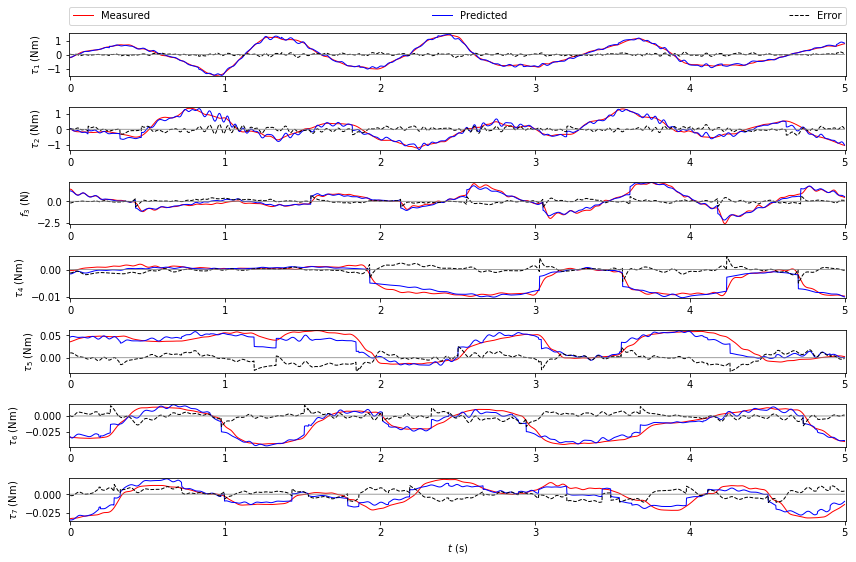

In [84]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [85]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [104]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [87]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.16453677, 0.24382768, 0.15751331, 0.20588095, 0.29879068,
       0.26129296, 0.35815597])

In [88]:
from identification import barycentric2standard_params

In [89]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [90]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    0.290559039718859  ⎤
⎢                           ⎥
⎢I1xy   -0.0204781877447245 ⎥
⎢                           ⎥
⎢I1xz  2.02841290127503e-19 ⎥
⎢                           ⎥
⎢I1yy    0.462573062686208  ⎥
⎢                           ⎥
⎢I1yz  1.66160245432329e-17 ⎥
⎢                           ⎥
⎢I1zz  0.000252140883720293 ⎥
⎢                           ⎥
⎢r1x    0.0482036228684517  ⎥
⎢                           ⎥
⎢r1y    -0.0703800044637699 ⎥
⎢                           ⎥
⎢r1z   -5.29095265265752e-19⎥
⎢                           ⎥
⎢ m₁     2.25833457191799   ⎥
⎢                           ⎥
⎢Fc₁    0.0556683040846012  ⎥
⎢                           ⎥
⎢Fv₁     0.106785591665255  ⎥
⎢                           ⎥
⎢Fo₁    -0.200062541743711  ⎥
⎢                           ⎥
⎢I2xx  0.000343889808986614 ⎥
⎢                           ⎥
⎢I2xy   0.00012892518376155 ⎥
⎢                           ⎥
⎢I2xz  -0.000798414555285075⎥
⎢                           ⎥
⎢I2yy  0.000460481083087664 ⎥
⎢         